In [1]:
import keras 
import PIL
from PIL import Image
import pandas as pd
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

In [3]:
from keras.preprocessing.image import ImageDataGenerator

### Preprocessing

In [4]:
training_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [5]:
valid_datagen = ImageDataGenerator(rescale=1./255)

In [6]:
train = training_datagen.flow_from_directory('Dataset/train/reduced',
                                             target_size=(128, 128),
                                             class_mode='binary')

Found 1135 images belonging to 2 classes.


In [7]:
valid = valid_datagen.flow_from_directory('Dataset/valid/reduced',
                                             target_size=(128, 128),
                                             class_mode='binary')

Found 241 images belonging to 2 classes.


### Build the architecture

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

In [9]:
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units = 1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1843264   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0

### Compile and Train

In [11]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit_generator(train,
                   steps_per_epoch=1135//32,
                   epochs=12,
                   validation_data=valid,
                   validation_steps=241//32)

Epoch 1/12
35/35 [==============================] - 12s 338ms/step - loss: 0.6157 - accuracy: 0.6664 - val_loss: 0.2880 - val_accuracy: 0.9018
Epoch 2/12
35/35 [==============================] - 11s 316ms/step - loss: 0.2354 - accuracy: 0.9130 - val_loss: 0.0870 - val_accuracy: 0.9688
Epoch 3/12
35/35 [==============================] - 12s 330ms/step - loss: 0.1093 - accuracy: 0.9619 - val_loss: 0.0913 - val_accuracy: 0.9598
Epoch 4/12
35/35 [==============================] - 12s 335ms/step - loss: 0.1148 - accuracy: 0.9529 - val_loss: 0.0832 - val_accuracy: 0.9643
Epoch 5/12
35/35 [==============================] - 11s 312ms/step - loss: 0.0820 - accuracy: 0.9710 - val_loss: 0.0632 - val_accuracy: 0.9732
Epoch 6/12
35/35 [==============================] - 12s 329ms/step - loss: 0.1193 - accuracy: 0.9529 - val_loss: 0.0790 - val_accuracy: 0.9643
Epoch 7/12
35/35 [==============================] - 12s 333ms/step - loss: 0.0675 - accuracy: 0.9755 - val_loss: 0.0738 - val_accuracy: 0.9821

<AxesSubplot:>

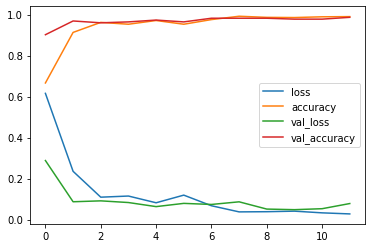

In [14]:
pd.DataFrame(history.history).plot()

In [15]:
model.save('final.h5')

In [12]:
model = load_model('final.h5')

### Live Video using Opencv

In [13]:
import cv2
import numpy as np

In [14]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') #import haar cascade

In [18]:
cap = cv2.VideoCapture(0)

while(True):
    
    ret, frame = cap.read()
    original_frame = cv2.flip(frame, 1)
    
    faces = face_cascade.detectMultiScale(original_frame, scaleFactor = 1.2, minNeighbors = 4)  
    
    H, W, _ = original_frame.shape
    for (x, y, w, h) in faces:
        X1, X2 = max(0, int(x - 0.5*w)), min(int(x + 1.5*w), W)
        Y1, Y2 = max(0, int(y - 0.5*h)), min(int(y + 1.5*h), H)
        cv2.rectangle(original_frame, (X1, Y1), (X2, Y2), (0, 255, 0), 2) 
        
        face = original_frame[Y1:Y2, X1:X2].copy()
    
    try:
        img_pil = Image.fromarray(face)
        resized = img_pil.resize((128, 128))
        frame = img_to_array(resized)
        frame_flatten = np.expand_dims(frame, axis = 0)

        prob = model.predict(frame_flatten)[0][0]
        if prob < 0.5 :
            pred = "No Mask , " + str(prob)
        else:
            pred = "Mask on , " + str(prob)

        font = cv2.FONT_HERSHEY_SIMPLEX   
        cv2.putText(original_frame, pred, (50, 50),font, 1, (0, 255, 0), 2, cv2.LINE_4)

    except:
        pass
    
    cv2.imshow('Live Video', original_frame)
    ch = cv2.waitKey(10)
    
    if ch & 0xFF == ord('q'):         #press 'q' to switch off live feed
        break
        
cap.release()
cv2.destroyAllWindows()

### Screenshots

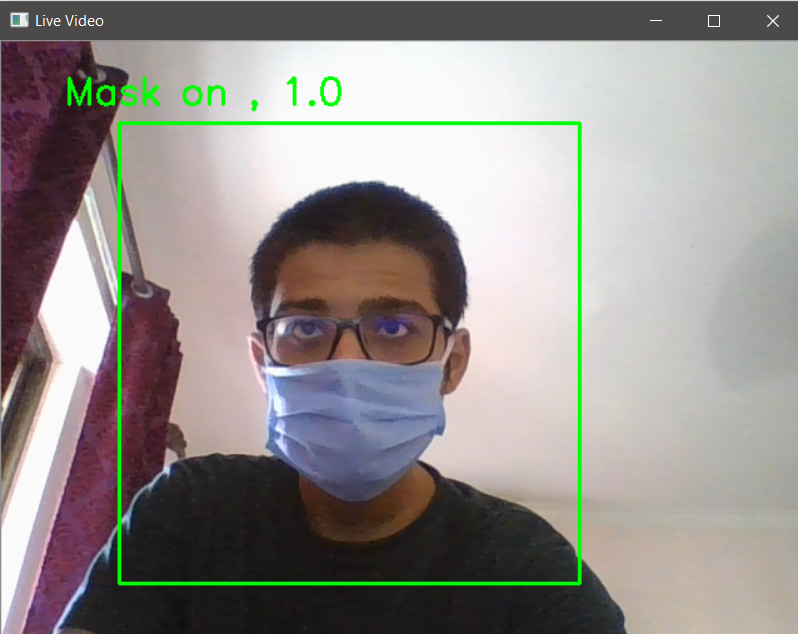

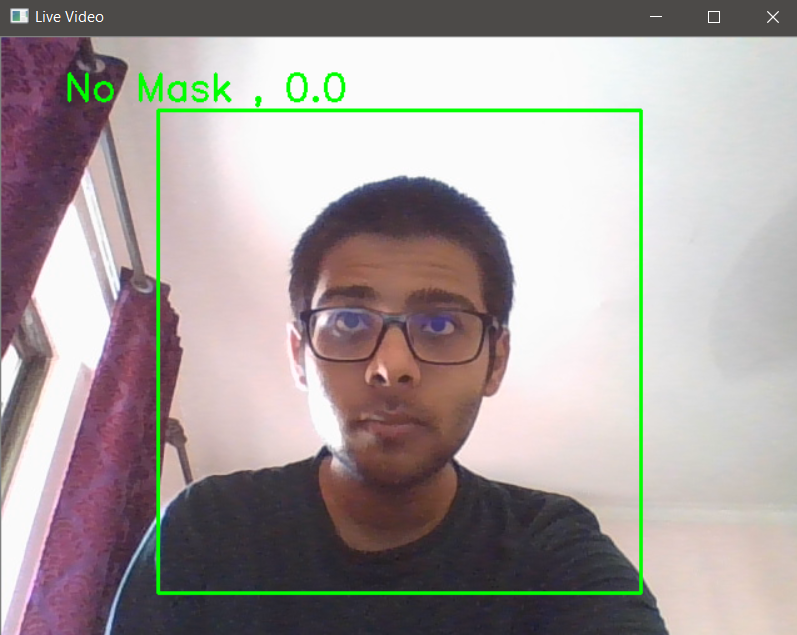